## Scrape data

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
# url = "https://paperswithcode.com/sota/multi-task-language-understanding-on-mmlu" # MMLU
# url = "https://paperswithcode.com/sota/sentence-completion-on-hellaswag" # Hellaswag
url = "https://paperswithcode.com/sota/common-sense-reasoning-on-arc-challenge" # ARC

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
scripts = soup.find_all('script')

chart_data, table_metrics, table_data = scripts[6:9]

import json
json_table = json.loads(table_data.string)

df  = pd.DataFrame(json_table)
# MMLU
# df.to_csv('mmlu_data/mmlu_benchmark_results.csv')
# df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
# df['mmlu_accuracy'] = df.raw_metrics.apply(lambda x: x['Average (%)'])
# df.to_csv('mmlu_data/mmlu_benchmark_results_clean.csv', index=False)

# Hellaswag
# df.to_csv('hellaswag_data/hellaswag_benchmark_results.csv')
# df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
# df['hellaswag_accuracy'] = df.raw_metrics.apply(lambda x: x['Accuracy'])
# df.to_csv('hellaswag_data/hellaswag_benchmark_results_clean.csv', index=False)

# ARC
df.to_csv('arc_data/arc_benchmark_results.csv')
df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
df['arc_accuracy'] = df.raw_metrics.apply(lambda x: x['Accuracy'])
df.to_csv('arc_data/arc_benchmark_results_clean.csv', index=False)


In [18]:
import pandas as pd

# Read the datasets
mmlu_df = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')
arc_df = pd.read_csv('arc_data/arc_benchmark_results_clean.csv')
hellaswag_df = pd.read_csv('hellaswag_data/hellaswag_benchmark_results_clean.csv')

# Function to strip whitespace and convert to lowercase
def clean_string(s):
    return s.strip().lower() if isinstance(s, str) else s

# Apply cleaning to method_short in all datasets
mmlu_df['method_short_clean'] = mmlu_df['method_short'].apply(clean_string)
arc_df['method_short_clean'] = arc_df['method_short'].apply(clean_string)
hellaswag_df['method_short_clean'] = hellaswag_df['method_short'].apply(clean_string)

# Create a dictionary mapping cleaned method_short to open_weights from MMLU dataset
open_weights_dict = dict(zip(mmlu_df['method_short_clean'], mmlu_df['open_weights']))

# Update ARC dataset
arc_df['open_weights'] = arc_df['method_short_clean'].map(open_weights_dict)

# Update Hellaswag dataset
hellaswag_df['open_weights'] = hellaswag_df['method_short_clean'].map(open_weights_dict)

# Remove the temporary cleaned column
arc_df = arc_df.drop(columns=['method_short_clean'])
hellaswag_df = hellaswag_df.drop(columns=['method_short_clean'])

# Save updated datasets
arc_df.to_csv('arc_data/arc_benchmark_results_clean_labeled.csv', index=False)
hellaswag_df.to_csv('hellaswag_data/hellaswag_benchmark_results_clean_labeled.csv', index=False)

# Print some information about the updates
print(f"ARC dataset: {arc_df['open_weights'].notna().sum()} rows updated with open_weights")
print(f"Hellaswag dataset: {hellaswag_df['open_weights'].notna().sum()} rows updated with open_weights")

ARC dataset: 20 rows updated with open_weights
Hellaswag dataset: 19 rows updated with open_weights


In [11]:
# Did some manual labeling of whether weights were openly available or not -> new CSV file.
# this could probably be automated by checking against the names of the other dataset, but it wasn't standardized

## Plots

### Data Prep

In [1]:
import pandas as pd
import numpy as np

# Set up the data
df_research = pd.read_csv('papers_with_models.csv')
df_released = pd.read_csv('Epoch Database - Notable Systems.csv')

df_research['date'] = pd.to_datetime(df_research['publication date (first revision)'])
df_research['year'] = pd.to_datetime(df_research['date']).dt.year
df_research['param count'] = pd.to_numeric(df_research['param count'], errors='coerce')
df_research['mmlu_accuracy'] = pd.to_numeric(df_research['mmlu_accuracy'], errors='coerce')
df_research['hellaswag_accuracy'] = pd.to_numeric(df_research['hellaswag_accuracy'], errors='coerce')
df_research['arc_accuracy'] = pd.to_numeric(df_research['arc_accuracy'], errors='coerce')
df_research['Type'] = 'Models used in research'

df_released['date'] = pd.to_datetime(df_released['Publication date'])
df_released['year'] = df_released['date'].dt.year
df_released['param count'] = pd.to_numeric(df_released['Parameters'], errors='coerce')
df_released['Type'] = 'Models released'

In [2]:
from scipy import interpolate

# Prep the dataset of research models
df_research = df_research.sort_values(['date', 'param count'])

# Create masks for rows with missing accuracies
mmlu_mask = df_research['mmlu_accuracy'].isna() | (df_research['mmlu_accuracy'] == 0)
hellaswag_mask = df_research['hellaswag_accuracy'].isna() | (df_research['hellaswag_accuracy'] == 0)
arc_mask = df_research['arc_accuracy'].isna() | (df_research['arc_accuracy'] == 0)

# Perform nearest neighbor interpolations

f = interpolate.interp1d(df_research.loc[~mmlu_mask, 'param count'], 
                         df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
                         kind='nearest')
df_research.loc[mmlu_mask, 'mmlu_accuracy'] = f(df_research.loc[mmlu_mask, 'param count'])

f = interpolate.interp1d(df_research.loc[~hellaswag_mask, 'param count'], 
                         df_research.loc[~hellaswag_mask, 'hellaswag_accuracy'], 
                         kind='nearest')
df_research.loc[hellaswag_mask, 'hellaswag_accuracy'] = f(df_research.loc[hellaswag_mask, 'param count'])

f = interpolate.interp1d(df_research.loc[~arc_mask, 'param count'], 
                         df_research.loc[~arc_mask, 'arc_accuracy'], 
                         kind='nearest')
df_research.loc[arc_mask, 'arc_accuracy'] = f(df_research.loc[arc_mask, 'param count'])


In [3]:
# Prep the dataset of released models
df_released = df_released[(df_released['year'] >= 2019) & 
                            (df_released['year'] <= 2024)]


df_released = df_released.sort_values(by='date')
df_released = df_released[df_released['Domain'].str.contains('Language')]
df_released = df_released[df_released['Model accessibility'].str.contains('Open access', na=False)]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=['param count'])

In [4]:
# Combine both DataFrames
df_combined = pd.concat([df_research[['year', 'date', 'param count', '' 'Type']], 
                         df_released[['year', 'date', 'param count', 'Type']]], ignore_index=True)

In [5]:
def get_max_list(df, metric='mmlu_accuracy'):
    max_score = 0
    max_score_list = []

    for i,x in df.iterrows():

        if x[metric] > max_score:
            max_score = x[metric]
            if len(max_score_list) == 0:
                max_score_list.append(x)
            else:
                if max_score_list[-1].evaluation_date == x.evaluation_date:
                    max_score_list[-1] = x
                else:
                    max_score_list.append(x)

    return max_score_list


In [6]:
# Define color palette
palette = {
    "bg_light_blue": "#93bed9",
    "bg_dark_blue": "#52778d",
    "bg_very_light_blue": "#c9eafb",
    "bg_brown": "#8c6443",
    "bg_light_brown": "#d8b294",
    "bg_muted_brown": "#a68e82",
    "fg_bright_blue": "#2991cf",
    "fg_deep_blue": "#06608e",
    "fg_light_blue": "#4babe1",
    "fg_deep_brown": "#8c4720",
    "fg_bright_orange": "#da6f27",
    "fg_burnt_orange": "#a54a24",
    "contrast_light_blue": "#4babe1",
    "contrast_orange": "#ee8c44"
}

### MMLU Plot

In [7]:
import pandas as pd

# Set up a list of open and closed models with highest MMLU scores

mmlu_df  = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')

mmlu_df['evaluation_date'] = pd.to_datetime(mmlu_df['evaluation_date'])
mmlu_df['open_weights'] = mmlu_df['open_weights'].astype(bool)
mmlu_df = mmlu_df[['rank', 'method_short', 'evaluation_date', 'mmlu_accuracy', 'open_weights']]

open_mmlu_df = mmlu_df[mmlu_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_mmlu_df = mmlu_df[mmlu_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_mmlu_df)
max_open = get_max_list(open_mmlu_df)

/var/folders/c9/bx81pd553cn7j4z_dnfy0mmr0000gn/T/ipykernel_9257/1585939643.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mmlu_df['evaluation_date'] = pd.to_datetime(mmlu_df['evaluation_date'])


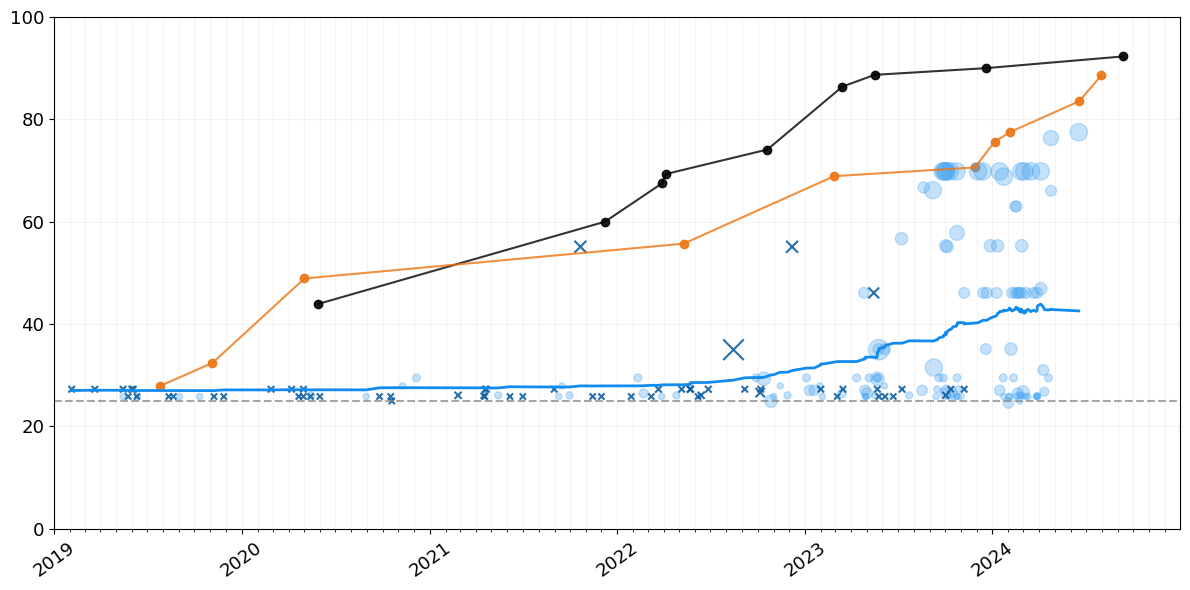

In [9]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# from adjustText import adjust_text

# Ensure the date column is in datetime format
df_research['date'] = pd.to_datetime(df_research['date'])

# Sort the dataframe by date
df_research = df_research.sort_values('date')


# Set up the plot
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
ax = plt.gca()


# Calculate the rolling average
window_size = 90
df_research['rolling_avg'] = df_research['mmlu_accuracy'].rolling(window=window_size, center=True, min_periods=1).mean()
# Plot the rolling average
plt.plot(df_research['date'], df_research['rolling_avg'], color="#118BEE", linewidth=2, label='90-day rolling average')

# Add horizontal dashed line for random baseline
plt.axhline(y=25, color='gray', linestyle='--', alpha=0.7, label='Random baseline (25%)')

# Add specific markers for Yi-34B and QWEN Chat 72B
# outlier_models = df_research[df_research['model'].isin(['Yi-34B', 'QWEN Chat 72B'])]

# plt.scatter(outlier_models['date'], outlier_models['mmlu_accuracy'], 
#             color=palette['fg_bright_blue'], s=50, marker='D', label='Outlier models')

# Filter out 60B-70B models
# models_60_70B = df_research[(df_research['param count'] >= 60e9) & (df_research['param count'] <= 70e9)]
# df_research = df_research[~df_research.index.isin(models_60_70B.index)]

# Function to scale parameter count to marker size with more pronounced differences
def scale_marker_size(param_count):
    # Convert to log scale
    log_param = np.log10(param_count)
    # Scale to 0-1 range
    normalized = (log_param - np.log10(df_research['param count'].min())) / (np.log10(df_research['param count'].max()) - np.log10(df_research['param count'].min()))
    # Apply power function to create more pronounced differences
    powered = np.power(normalized, 3)  # You can adjust this power (3) to increase or decrease the effect
    # Scale to 20-120 range
    scaled_size = 20 + powered * 200
    return scaled_size

def scale_marker_size2(param_count):
    # Convert to log scale
    log_param = np.log10(param_count)
    # Scale to 0-1 range
    normalized = (log_param - np.log10(df_research['param count'].min())) / (np.log10(df_research['param count'].max()) - np.log10(df_research['param count'].min()))
    # Apply power function to create more pronounced differences
    powered = np.power(normalized, 3)  # You can adjust this power (3) to increase or decrease the effect
    # Scale to 20-120 range
    scaled_size = 200 + powered * 200
    return scaled_size

# Plot original data points with scaled marker size
plt.scatter(df_research.loc[~mmlu_mask, 'date'], 
            df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
            color="#41A2F1", alpha=0.3, 
            s=df_research.loc[~mmlu_mask, 'param count'].apply(scale_marker_size),
            label='Models with MMLU available')

# Plot interpolated data points with 'X' marker and scaled marker size
plt.scatter(df_research.loc[mmlu_mask, 'date'], 
            df_research.loc[mmlu_mask, 'mmlu_accuracy'], 
            color="#0C5FA3", alpha=0.3, 
            s=df_research.loc[mmlu_mask, 'param count'].apply(scale_marker_size),
            marker='o', label='Models with MMLU interpolated')
plt.scatter(df_research.loc[mmlu_mask, 'date'], 
            df_research.loc[mmlu_mask, 'mmlu_accuracy'], 
            color="#0C5FA3", alpha=0.3, 
            s=df_research.loc[mmlu_mask, 'param count'].apply(scale_marker_size2),
            marker='|', label='Models with MMLU interpolated')


plt.plot([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], color='black', alpha=0.8, )
plt.scatter([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], 
            color='black', alpha=0.9, label='Highest scoring closed models') 

plt.plot([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], color='#EE7411', alpha=0.8)
plt.scatter([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], 
            color='#EE7411', alpha=0.9, label='Highest scoring open models')  

# # Plot original data points
# plt.scatter(df_research.loc[~mmlu_mask, 'date'], 
#             df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
#             color="#41A2F1", alpha=0.3, s=25, label='Models with MMLU available')

# # Plot interpolated data points with 'X' marker
# plt.scatter(df_research.loc[mmlu_mask, 'date'], 
#             df_research.loc[mmlu_mask, 'mmlu_accuracy'], 
#             color="#0C5FA3", alpha=0.9, s=50, marker='x', label='Models with MMLU interpolated')

# # Plot original academic data points
# plt.scatter(df_research.loc[~mmlu_mask & ~df_research['non-academia'], 'date'], 
#             df_research.loc[~mmlu_mask & ~df_research['non-academia'], 'mmlu_accuracy'], 
#             color=palette['fg_bright_blue'], alpha=0.3, s=25, label='Models from academic papers with MMLU available')

# # Plot original non-academic data points
# plt.scatter(df_research.loc[~mmlu_mask & df_research['non-academia'], 'date'], 
#             df_research.loc[~mmlu_mask & df_research['non-academia'], 'mmlu_accuracy'], 
#             color='orange', alpha=0.3, s=25, label='Models from non-academic papers with MMLU available')

# # Plot interpolated academic data points with 'X' marker
# plt.scatter(df_research.loc[mmlu_mask & ~df_research['non-academia'], 'date'], 
#             df_research.loc[mmlu_mask & ~df_research['non-academia'], 'mmlu_accuracy'], 
#             color=palette['fg_bright_blue'], alpha=0.6, s=50, marker='x', label='Models from academic papers with MMLU interpolated')

# # Plot interpolated non-academic data points with 'X' marker
# plt.scatter(df_research.loc[mmlu_mask & df_research['non-academia'], 'date'], 
#             df_research.loc[mmlu_mask & df_research['non-academia'], 'mmlu_accuracy'], 
#             color='orange', alpha=0.6, s=50, marker='x', label='Models from non-academic papers with MMLU interpolated')

# Add markers for models with param count between 60B and 70B
# plt.scatter(models_60_70B['date'], models_60_70B['mmlu_accuracy'], 
#             color='purple', s=100, lw=3, marker='_', label='60B-70B models')

# # Academic models 60B-70B
# plt.scatter(models_60_70B[~models_60_70B['non-academia']]['date'], 
#             models_60_70B[~models_60_70B['non-academia']]['mmlu_accuracy'], 
#             color='purple', s=100, marker='_', lw=3, label='60B-70B models from academic papers')

# # Non-academic models 60B-70B
# plt.scatter(models_60_70B[models_60_70B['non-academia']]['date'], 
#             models_60_70B[models_60_70B['non-academia']]['mmlu_accuracy'], 
#             color='orange', s=100, marker='_', lw=3, label='60B-70B models from non-academic papers')


# # Create text annotations (unchanged)
# texts = []
# for point in max_closed:
#     texts.append(plt.text(point.evaluation_date, point.mmlu_accuracy, point.method_short,
#                         fontsize=9,
#                         bbox=dict(boxstyle="round,pad=0.3", fc=palette['bg_light_blue'], ec="gray", alpha=0.8)))
    
# for point in max_open:
#     texts.append(plt.text(point.evaluation_date, point.mmlu_accuracy, point.method_short,
#                         fontsize=9,
#                         bbox=dict(boxstyle="round,pad=0.3", fc=palette['bg_muted_brown'], ec="gray", alpha=0.8)))

# # Use adjust_text to prevent overlap (unchanged)
# adjust_text(texts, 
#             force_points=(0, 0),
#             force_text=(0.5, 1.2),
#             expand_points=(0, 0),
#             expand_text=(0.1, 0.5),
#             )

# # Set labels and title
# ax.set_title('MMLU Score Trends Comparison', fontsize=16)   
# ax.set_xlabel('Publication Date', fontsize=14)  
# ax.set_ylabel("MMLU Average (%)", fontsize=14)  

# Customize the x-axis (unchanged)
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Set font size for y-axis tick labels
ax.tick_params(axis='y', which='major', labelsize=13)  # Adjust the size (16) as needed
ax.tick_params(axis='y', which='minor', labelsize=13)  # Adjust the size (16) as needed
#ySet font size for y-axis tick labels and rotate them slightly
ax.tick_params(axis='x', which='major', labelsize=13, rotation=36)  # Adjust the size (16) and rotation (15) as needed
ax.tick_params(axis='x', which='minor', labelsize=13, rotation=36)  # Adjust the size (16) and rotation (15) as needed

# # Remove x-axis labels
# ax.set_xticklabels([])

# # Remove y-axis labels
# ax.set_yticklabels([])

# Set y-axis limits to 0-100
ax.set_ylim(0, 100)

# Customize the grid (unchanged)
plt.grid(True, which="both", ls="-", alpha=0.1, color=palette['bg_muted_brown'])

# Add legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot with tight layout
plt.tight_layout()
# Save the current figure as a PDF
plt.savefig('scatterplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()



### Hellaswag Plot

In [78]:
import pandas as pd
hellaswag_df  = pd.read_csv('hellaswag_data/hellaswag_benchmark_results_clean_labeled.csv')

hellaswag_df['evaluation_date'] = pd.to_datetime(hellaswag_df['evaluation_date'])
hellaswag_df['open_weights'] = hellaswag_df['open_weights'].map({'TRUE': True, 'FALSE': False})
hellaswag_df = hellaswag_df[['rank', 'method_short', 'evaluation_date', 'hellaswag_accuracy', 'open_weights']]

open_hellaswag_df = hellaswag_df[hellaswag_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_hellaswag_df = hellaswag_df[hellaswag_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_hellaswag_df, metric='hellaswag_accuracy')
max_open = get_max_list(open_hellaswag_df, metric='hellaswag_accuracy')

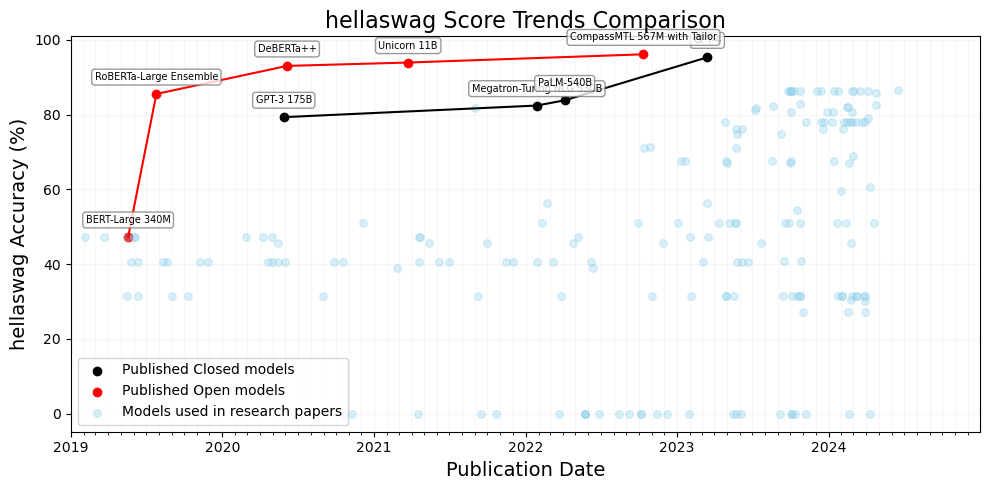

In [79]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.hellaswag_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.hellaswag_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.hellaswag_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.hellaswag_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['hellaswag_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.hellaswag_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.hellaswag_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('hellaswag Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("hellaswag Accuracy (%)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### ARC Plot

In [76]:
import pandas as pd
arc_df  = pd.read_csv('arc_data/arc_benchmark_results_clean_labeled.csv')

arc_df['evaluation_date'] = pd.to_datetime(arc_df['evaluation_date'])
arc_df['open_weights'] = arc_df['open_weights'].map({'TRUE': True, 'FALSE': False})
arc_df = arc_df[['rank', 'method_short', 'evaluation_date', 'arc_accuracy', 'open_weights']]

open_arc_df = arc_df[arc_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_arc_df = arc_df[arc_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_arc_df, metric='arc_accuracy')
max_open = get_max_list(open_arc_df, metric='arc_accuracy')

AttributeError: 'Series' object has no attribute 'arc_accuracy'

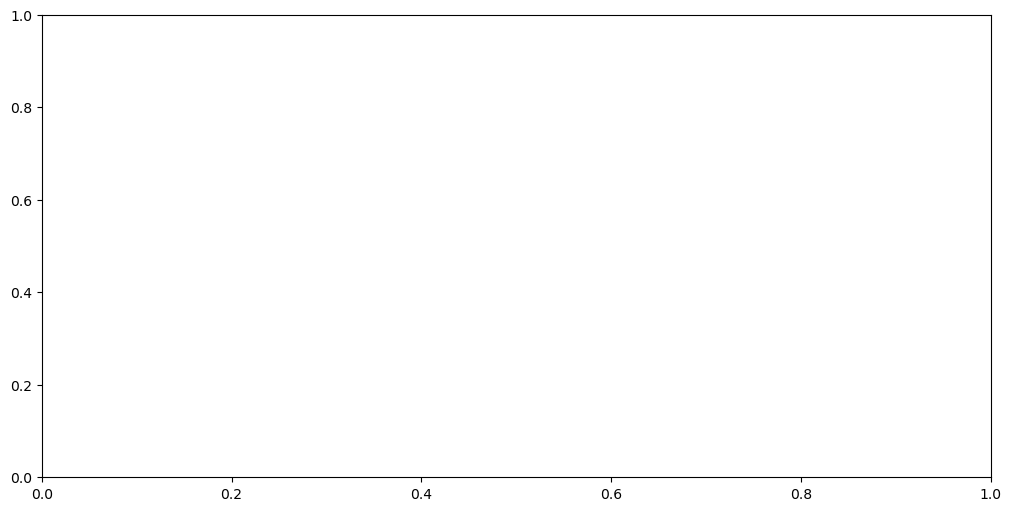

In [73]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.arc_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.arc_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.arc_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.arc_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['arc_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.arc_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.arc_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('ARC Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("ARC Accuracy", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
# Save the plot as a PDF file
plt.show()

### Model size VS MMLU Bubble Plot


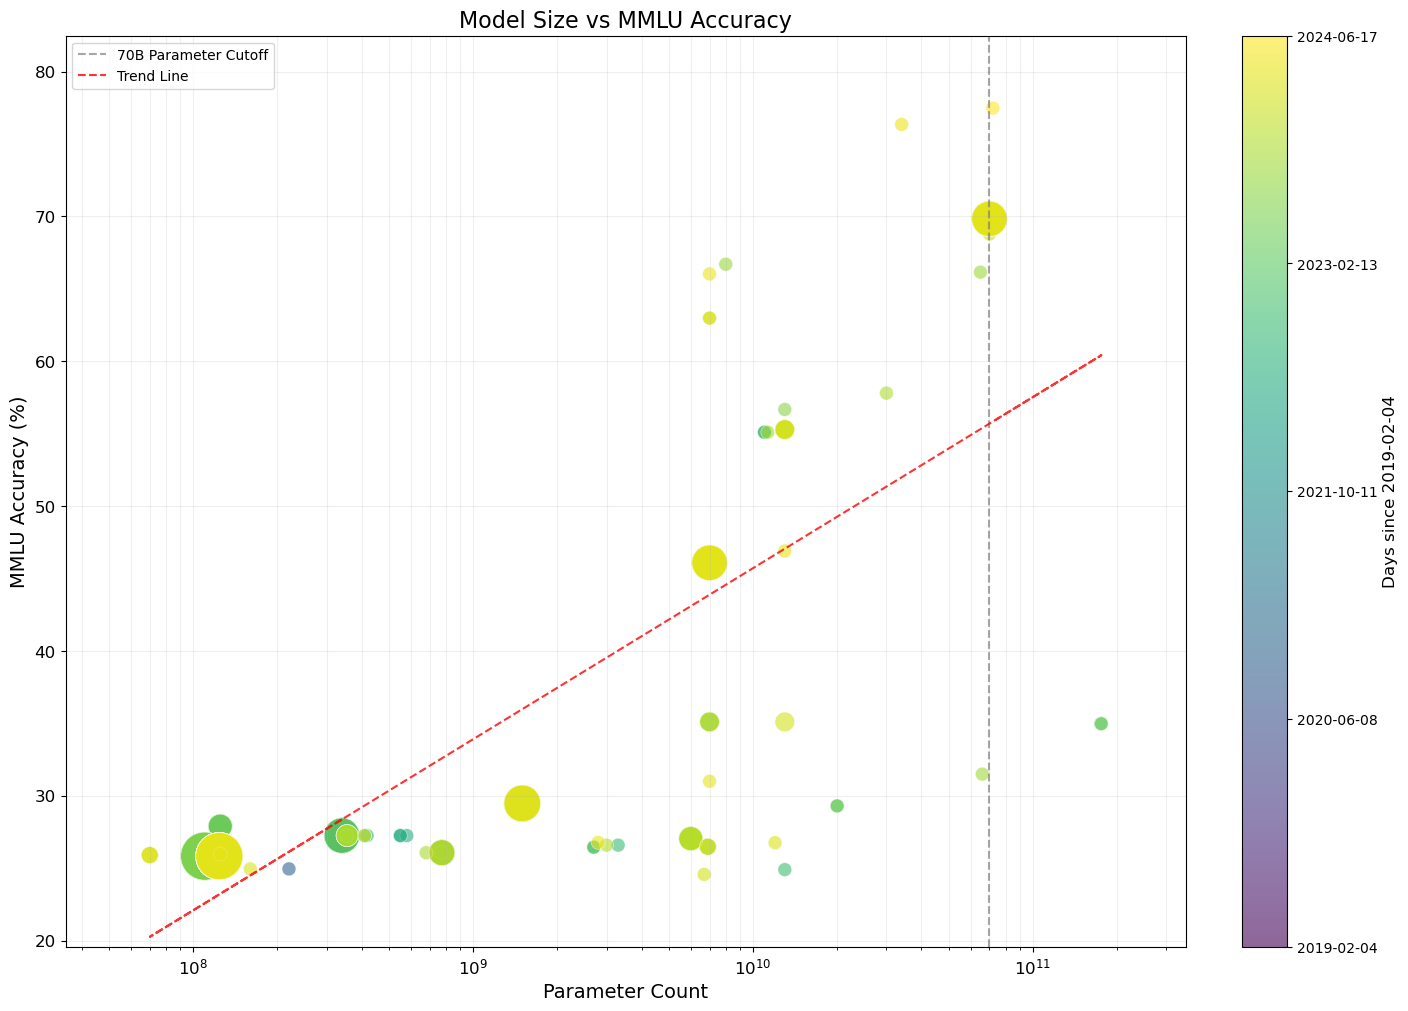

In [85]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd

# ... [previous code remains the same] ...

# Create the plot with constrained_layout=True
fig, ax = plt.subplots(figsize=(14, 10), constrained_layout=True)

# Create a scatter plot with larger base size and adjusted scaling
scatter = ax.scatter(
    df_research['param count'], 
    df_research['mmlu_accuracy'],
    s=model_counts[df_research['model']].map(lambda x: max(100, x * 50)),  # Increased base size and scaling
    alpha=0.6,
    c=df_research['days_since_min'],  # Use this for color mapping
    cmap='viridis',
    edgecolor='w',
    linewidth=0.5
)

# Set the x-axis to logarithmic scale with adjusted limits
ax.set_xscale('log')
ax.set_xlim(df_research['param count'].min() * 0.5, df_research['param count'].max() * 2)

# Set y-axis limits to focus on the data range
y_min = max(0, df_research['mmlu_accuracy'].min() - 5)
y_max = min(100, df_research['mmlu_accuracy'].max() + 5)
ax.set_ylim(y_min, y_max)

# Add a dashed grey cutoff line at 70 billion parameters
cutoff_line = ax.axvline(x=70e9, color='grey', linestyle='--', linewidth=1.5, alpha=0.7)

# Add labels and title
ax.set_xlabel('Parameter Count', fontsize=14)
ax.set_ylabel('MMLU Accuracy (%)', fontsize=14)
ax.set_title('Model Size vs MMLU Accuracy', fontsize=16)

# Add a colorbar to show the date progression
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Days since ' + min_date.strftime('%Y-%m-%d'), fontsize=12)

# Customize the colorbar ticks to show actual dates
cbar_ticks = np.linspace(df_research['days_since_min'].min(), df_research['days_since_min'].max(), 5)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([(min_date + pd.Timedelta(days=tick)).strftime('%Y-%m-%d') for tick in cbar_ticks])

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a grid for better readability
ax.grid(True, which="both", ls="-", alpha=0.2)

# Add a trend line
valid = df_research[['param count', 'mmlu_accuracy']].dropna()
log_param = np.log10(valid['param count'])
z = np.polyfit(log_param, valid['mmlu_accuracy'], 1)
p = np.poly1d(z)
trend_line = ax.plot(valid['param count'], 
        p(log_param), 
        "r--", alpha=0.8, label="Trend Line")

# Add legend
ax.legend([cutoff_line, trend_line[0]], ['70B Parameter Cutoff', 'Trend Line'], fontsize=10)

# Show the plot
plt.show()

## Data Stats


In [11]:
import pandas as pd
import numpy as np

# Assuming df_research is already loaded and date column is in datetime format

# Filtering for dates after the release of Llama 65B
start_date = pd.to_datetime('2023-02-27')
end_date = df_research['date'].max()
filtered_df = df_research[(df_research['date'] >= start_date) & (df_research['date'] <= end_date)]
# filtered_df = df_research

# Convert param count to billions
filtered_df['param_count_B'] = filtered_df['param count'] / 1e9

# Calculate statistics for model sizes
model_size_stats = filtered_df['param_count_B'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

# Calculate statistics for MMLU accuracy scores
mmlu_stats = filtered_df['mmlu_accuracy'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

print("Model Size Statistics (in billions of parameters):")
print(model_size_stats)
print("\nMMLU Accuracy Statistics:")
print(mmlu_stats)

# Calculate percentage of models under 1B
under_1B_percentage = (filtered_df['param_count_B'] < 1).mean() * 100

print(f"\nPercentage of models under 1B parameters: {under_1B_percentage:.2f}%")

# Get distribution of model sizes for small models
small_model_distribution = filtered_df[filtered_df['param_count_B'] < 1]['param_count_B'].describe(percentiles=[0.25, 0.5, 0.75])
print("\nDistribution of model sizes under 1B:")
print(small_model_distribution)

# Print unique values and their counts for very small models
very_small_models = filtered_df[filtered_df['param_count_B'] < 0.1]['param_count_B']
print("\nUnique values and counts for models under 0.1B:")
print(very_small_models.value_counts().sort_index())

Model Size Statistics (in billions of parameters):
count    109.000000
mean      16.468376
std       28.733194
min        0.070000
10%        0.124000
25%        0.354000
50%        6.900000
75%       13.000000
90%       70.000000
max      176.000000
Name: param_count_B, dtype: float64

MMLU Accuracy Statistics:
count    109.000000
mean      40.010367
std       16.979686
min       24.570000
10%       25.830000
25%       26.070000
50%       29.470000
75%       55.100000
90%       69.830000
max       77.480000
Name: mmlu_accuracy, dtype: float64

Percentage of models under 1B parameters: 33.03%

Distribution of model sizes under 1B:
count    36.000000
mean      0.218139
std       0.190425
min       0.070000
25%       0.124000
50%       0.124000
75%       0.343500
max       0.774000
Name: param_count_B, dtype: float64

Unique values and counts for models under 0.1B:
0.07    3
Name: param_count_B, dtype: int64


/var/folders/03/b2l89whs7p3_sm3vkwp7yznh0000gn/T/ipykernel_26442/1003866159.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['param_count_B'] = filtered_df['param count'] / 1e9


/var/folders/03/b2l89whs7p3_sm3vkwp7yznh0000gn/T/ipykernel_26442/2705817442.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['mmlu_category'] = filtered_df['mmlu_accuracy'].apply(categorize_mmlu_accuracy)
/var/folders/03/b2l89whs7p3_sm3vkwp7yznh0000gn/T/ipykernel_26442/2705817442.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model_size_category'] = filtered_df['param_count_B'].apply(categorize_model_size)


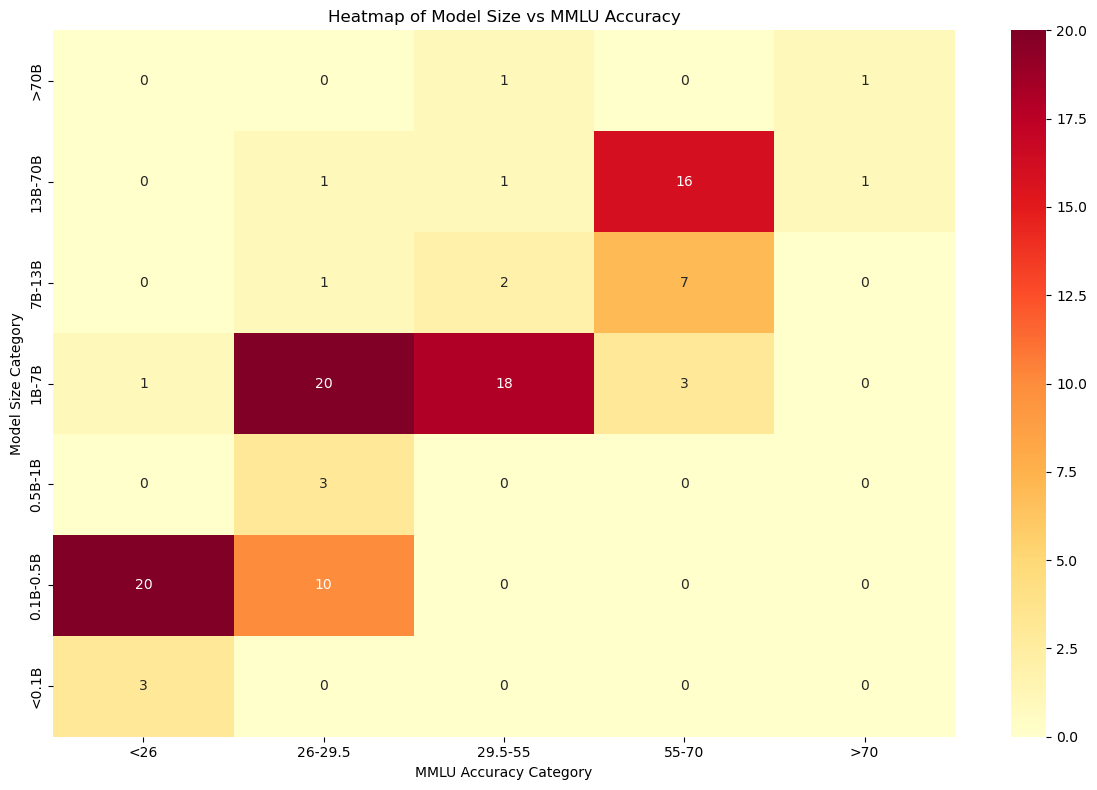

Distribution of model sizes:
<0.1B         3
0.1B-0.5B    30
0.5B-1B       3
1B-7B        42
7B-13B       10
13B-70B      19
>70B          2
Name: model_size_category, dtype: int64

Distribution of MMLU accuracy scores:
<26        24
26-29.5    35
29.5-55    22
55-70      26
>70         2
Name: mmlu_category, dtype: int64

Most common combinations of model size and MMLU accuracy:
model_size_category  mmlu_category
0.1B-0.5B            <26              20
1B-7B                26-29.5          20
                     29.5-55          18
13B-70B              55-70            16
0.1B-0.5B            26-29.5          10
dtype: int64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the categorization function
def categorize_model_size(size):
    if size <= 0.1:
        return '<0.1B'
    elif size <= 0.5:
        return '0.1B-0.5B'
    elif size <= 1:
        return '0.5B-1B'
    elif size <= 7:
        return '1B-7B'
    elif size <= 13:
        return '7B-13B'
    elif size <= 70: 
        return '13B-70B'
    else:
        return '>70B'

def categorize_mmlu_accuracy(score):
    if score < 26:
        return '<26'
    elif score < 29.5:
        return '26-29.5'
    elif score < 55:
        return '29.5-55'
    elif score < 70:
        return '55-70'
    else:
        return '>70'

filtered_df['mmlu_category'] = filtered_df['mmlu_accuracy'].apply(categorize_mmlu_accuracy)

# Apply the updated categorization
filtered_df['model_size_category'] = filtered_df['param_count_B'].apply(categorize_model_size)

# Define the order for model sizes and MMLU accuracy categories
model_size_order = ['<0.1B', '0.1B-0.5B', '0.5B-1B', '1B-7B', '7B-13B', '13B-70B', '>70B']
mmlu_accuracy_order = ['<26', '26-29.5', '29.5-55', '55-70', '>70']

# Create the crosstab with ordered indices
heatmap_data = pd.crosstab(
    pd.Categorical(filtered_df['model_size_category'], categories=model_size_order[::-1], ordered=True),
    pd.Categorical(filtered_df['mmlu_category'], categories=mmlu_accuracy_order, ordered=True)
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap of Model Size vs MMLU Accuracy')
plt.xlabel('MMLU Accuracy Category')
plt.ylabel('Model Size Category')
plt.tight_layout()
plt.show()

# Print out the distribution of model sizes and MMLU accuracy scores
print("Distribution of model sizes:")
print(filtered_df['model_size_category'].value_counts()[model_size_order])

print("\nDistribution of MMLU accuracy scores:")
print(filtered_df['mmlu_category'].value_counts()[mmlu_accuracy_order])

# Most common combinations
common_combinations = filtered_df.groupby(['model_size_category', 'mmlu_category']).size().sort_values(ascending=False).head(5)
print("\nMost common combinations of model size and MMLU accuracy:")
print(common_combinations)

In [30]:
# Set the parameter threshold as a variable
param_threshold = 8  # Change this value as needed

# First, let's create boolean masks for our conditions
under_55_mmlu = filtered_df['mmlu_accuracy'] < 47
under_param_threshold = filtered_df['param_count_B'] < param_threshold

# Combine these conditions
target_papers = under_55_mmlu & under_param_threshold

# Calculate the percentage
percentage = (target_papers.sum() / len(filtered_df)) * 100

print(f"Percentage of papers studying models with MMLU scores under 55 and size under {param_threshold}B params: {percentage:.2f}%")

# For additional context, let's print the actual count
count = target_papers.sum()
total = len(filtered_df)
print(f"Number of such papers: {count} out of {total} total papers")

# Let's also break this down by our existing categories
size_categories = ['<0.1B', '0.1B-0.5B', '0.5B-1B', '1B-7B']
mmlu_categories = ['<26', '26-29.5', '29.5-55']

breakdown = filtered_df[target_papers].groupby(['model_size_category', 'mmlu_category']).size().unstack(fill_value=0)

# Ensure all categories are present, add missing ones with zeros
for category in size_categories + mmlu_categories:
    if category not in breakdown.index and category not in breakdown.columns:
        if category in size_categories:
            breakdown.loc[category] = 0
        else:
            breakdown[category] = 0

# Reorder and select only the categories we want
breakdown = breakdown.reindex(index=size_categories, columns=mmlu_categories, fill_value=0)

print("\nBreakdown of these papers by category:")
print(breakdown)

# Calculate percentage for each cell
percentage_breakdown = breakdown / total * 100

print("\nPercentage breakdown:")
print(percentage_breakdown)

Percentage of papers studying models with MMLU scores under 55 and size under 8B params: 68.81%
Number of such papers: 75 out of 109 total papers

Breakdown of these papers by category:
mmlu_category        <26  26-29.5  29.5-55
model_size_category                       
<0.1B                  3        0        0
0.1B-0.5B             20       10        0
0.5B-1B                0        3        0
1B-7B                  1       20       18

Percentage breakdown:
mmlu_category              <26    26-29.5    29.5-55
model_size_category                                 
<0.1B                 2.752294   0.000000   0.000000
0.1B-0.5B            18.348624   9.174312   0.000000
0.5B-1B               0.000000   2.752294   0.000000
1B-7B                 0.917431  18.348624  16.513761
